[*********************100%***********************]  1 of 1 completed
Up trend
buy:2018-06-08 00:00:00 2779.030029296875
利確:2018-06-27 00:00:00 2699.6298828125
Up trend
buy:2018-07-10 00:00:00 2793.840087890625
利確:2018-10-09 00:00:00 2880.340087890625
Up trend
buy:2019-02-22 00:00:00 2792.669921875
利確:2019-05-09 00:00:00 2870.719970703125
Up trend
buy:2019-06-20 00:00:00 2954.179931640625
利確:2019-08-01 00:00:00 2953.56005859375
Up trend
buy:2019-10-24 00:00:00 3010.2900390625
利確:2020-01-31 00:00:00 3225.52001953125
Up trend
buy:2020-02-05 00:00:00 3334.68994140625
損切り:2020-02-25 00:00:00 3128.2099609375
Up trend
buy:2020-06-01 00:00:00 3055.72998046875
利確:2020-09-08 00:00:00 3331.840087890625
Up trend
buy:2020-11-13 00:00:00 3585.14990234375
最終日売:2021-02-02 00:00:00 3826.31005859375
[-2.857117254845354, 3.0960970305679902, 2.7948182567785196, -0.020982914420208942, 7.149808745199171, -6.191879427976943, 9.035814983217838, 6.726640804958928]
The period is from 2018-01-02 00:00:00 up to 2

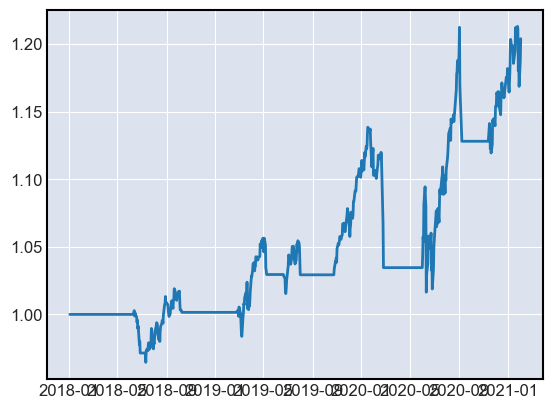

Axes(0.18,0.38;0.72x0.5)


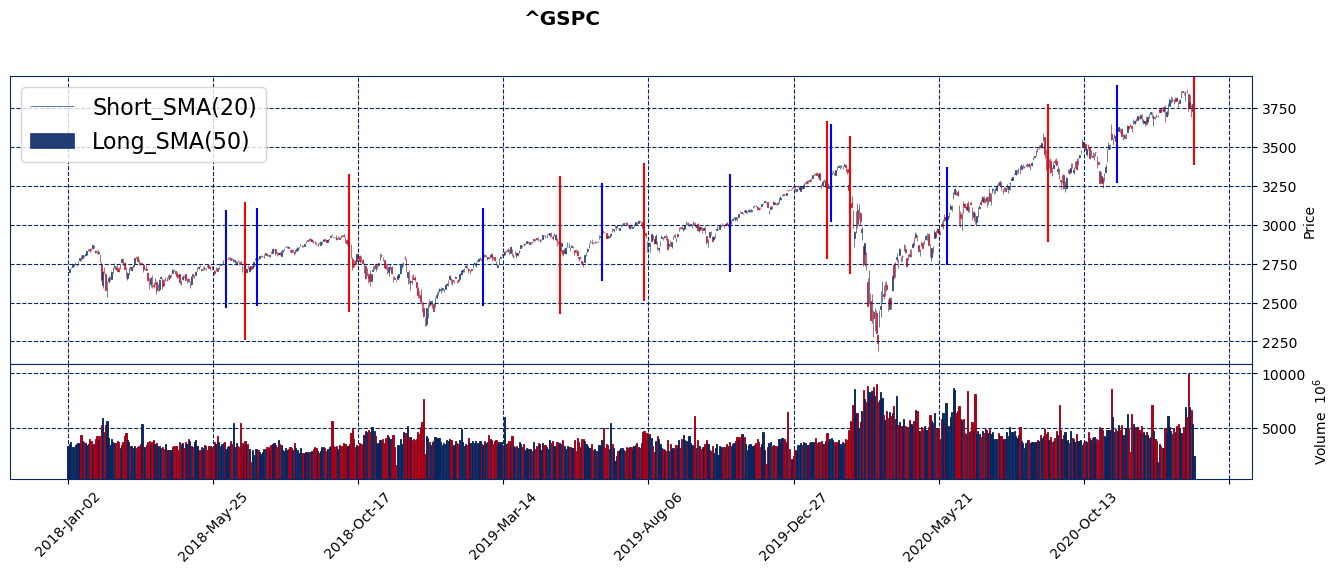

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

start = '2018-01-01'
end = dt.datetime.now()
stock_code = '^GSPC'
df = yf.download(stock_code, start, end, interval='1d')
# print(df.head(65))

# 何日間で最大最小の値を保持
shortTerm = 20
longTerm = 60

# 損切り率と利確の日数
stopLoss = 0.95
rikaku_day = 80

# judge U trend or Down trend by DC
buy_position = False # 1 means entered and 0 means not already entered
sell_position = False

# 買った（売った）後に経過した日数、損切りラインを保持
buy_dates = 0
sell_dates = 0
buy_stopLine = 0
sell_stopLine = 0
counter = 1
percentChange = []

# 資産、購入したときの資産
assets = [1]
buy_asset = 1

#　買った日、売った日
buy_days = []
sell_days = []

# 60日高値と安値
df['Highest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).max()
df['Lowest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).min()

# 20日高値と安値
df['Highest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).max()
df['Lowest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).min()


"""
メインループ
基本戦略
過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入or空売り
損切り率は5%。80日後に利確する。
最終日にまだ保持していた場合捌く
"""
# for i in range(1, len(df)):
for i in range(1,len(df)):
        
    longHighest = df['Highest'+str(longTerm)][i-1]
    shortLowest = df['Lowest'+str(shortTerm)][i-1]
    close = df['Adj Close'][i]
    sell_day = pd.to_datetime(df.index[i])
    
    if buy_position == False:
        assets.append(assets[i-1])
    else:
        assets.append(buy_asset*(close / buy_price))
        
    # avoid NaN data 
    # 買いトレンド
    if (np.isnan(longHighest)) == False:
        if (close > longHighest and buy_position == False):
            print('Up trend')
            buy_position = True
            buy_price = close
            buy_stopLine = close * stopLoss
            buy_asset = assets[i]
            buy_day = pd.to_datetime(df.index[i])
            buy_days.append(df.index[i])
            print('buy:'+str(df.index[i]),close)

    # 損切り
    if buy_position == True and close < buy_stopLine:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        sell_days.append(df.index[i])
        print('損切り:'+str(df.index[i]),close)

    # 利確
    if  buy_position == True and shortLowest > close:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        sell_days.append(df.index[i])
#         buy_dates = 0
        print('利確:'+str(df.index[i]),close)
#         print('Date:'+str(i),'Secure Profit Buy at the price {}'.format(close))
        
    # 損切りラインの更新
    # if buy_position = 

    #  最終日にまだ持ってたら利確する
    if (counter == df['Adj Close'].count() - 1):
        if buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            sell_days.append(df.index[i])
#             buy_dates = 0
            print('最終日売:'+str(df.index[i]),close)
#             print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

#     # 買ってからの日数を更新する
#     if buy_position == True:
#         buy_dates += 1
    counter += 1



print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

# 資産の計算とドローダウンの計算
assets = np.array(assets)
max_asset = 1
max_drawdown = 0
for i in range(len(assets)):
    max_asset = max(max_asset,assets[i])
    now_drawdown = 1 - (assets[i]/max_asset)
    if now_drawdown < 0:
        continue
    max_drawdown = max(max_drawdown, now_drawdown)  
print(max_drawdown)
plt.plot(df.index,assets)
plt.show()

buy_signals = []
sell_signals = []

for i in df.index:
    if i in buy_days:
        buy_signals.append(df['Adj Close'][i])
    else:
        buy_signals.append(np.nan)
    if i in sell_days:
        sell_signals.append(df['Adj Close'][i])
    else:
        sell_signals.append(np.nan)
adp = [
    mpf.make_addplot(buy_signals,type='scatter',color='b',marker='|',markersize=5000),
    mpf.make_addplot(sell_signals,type='scatter',color='r',marker='|',markersize=10000)
]
fig, ax = mpf.plot(df,type='candle',figratio=(45,15),
                  addplot=adp, volume=True, title=str(stock_code), returnfig=True, style='sas')
legend = ['Short_SMA(20)','Long_SMA(50)']
ax[0].legend(legend,fontsize=16)
print(ax[0])